In this notebook we plot and analyze the discovered frequency demultiplexers

In [1]:
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib.pyplot as plt
import glob

import autolattice.plothelpers as phelp
import autolattice.architecture as arch

import os
import glob
import autolattice.constraints as msc
import autolattice.architecture_optimizer as arch_opt

from IPython.display import display
import ipywidgets as widgets

from autolattice.definitions import LEFT_TO_RIGHT, RIGHT_TO_LEFT

def unify_dicts(*dicts):
    keys = dicts[0]
    unified_dict = {}
    for key in keys:
        to_unify = []
        for d in dicts:
            element = d[key]
            if len(element) != 0:
                to_unify.append(element.T)
        unified_dict[key] = np.hstack(to_unify).T

    return unified_dict

def get_solutions_for_graphs(list_of_graphs):
    return np.array([unified_dict['solutions'][np.where(np.all(unified_dict['graphs_tested'] == graph, -1))[0]][0] for graph in list_of_graphs])

I0000 00:00:1765296067.456743   27635 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
load_folder = 'results/frequency_demultiplexers'

print('#loading the following code:')
with open(os.path.join(load_folder, "setup.py")) as f:
    code = f.read()
    print(code)
    exec(code)

optimizer.prepare_all_possible_combinations()
num_chains = len(optimizer.list_possible_graphs)

plot_functions = phelp.prepare_plot_functions_for_plotting(optimizer, 51)

#loading the following code:
save_folder = 'frequency_splitter/test3'

target_scaling_rate = 1.1
omega_right = 3.
omega_left = -3.
constraints_scaling = [
    msc.Scaling_Rate_Constraint(target_scaling_rate, target_omega=omega_right),
    msc.Scaling_Rate_Constraint(0., gradient_order=1, target_omega=omega_right),
    msc.Scaling_Rate_Constraint(target_scaling_rate, target_omega=omega_left, direction=RIGHT_TO_LEFT),
    msc.Scaling_Rate_Constraint(0., gradient_order=1, target_omega=omega_left, direction=RIGHT_TO_LEFT),
    # msc.Scaling_Rate_Constraint(0., gradient_order=2, target_omega=0., kwargs_difference_quotient={'h': 1.e-4}),
    msc.Prefactor_Bulk_Constraint(0., gradient_order=1, target_omega=omega_right),
    msc.Prefactor_Bulk_Constraint(0., gradient_order=1, target_omega=omega_left, direction=RIGHT_TO_LEFT),
    msc.Min_Distance_Eigvals_range(jnp.linspace(-5., 5., 51), 0.05),
    msc.Stability_Constraint(10),
]

kwargs_bounds = {'bounds_extrinsic_loss': [0., np.inf]}

optimiz

288it [00:00, 570599.69it/s]


sorted out 8 graphs, where the unit cells were decoupled


In [3]:
all_result_files = sorted(glob.glob(os.path.join(load_folder, '*.npz')))
num_files = len(all_result_files)
if num_files % 32 != 0:
    raise Warning('sumething seems odd with the number of result files (%i)'%num_files)
all_data = [dict(np.load(filename)) for filename in all_result_files]

unified_dict = unify_dicts(*all_data)
idxs_success = np.where(unified_dict['success'])
valid_graphs = unified_dict['graphs_tested'][idxs_success]
optimizer.valid_combinations = valid_graphs
optimizer.cleanup_valid_combinations()
irreducible_graphs = optimizer.valid_combinations

irreducible_graphs_solutions = get_solutions_for_graphs(irreducible_graphs)

print('found %i irreducible graphs'%len(irreducible_graphs))

76it [00:00, 9357.34it/s]

found 3 irreducible graphs


Show all discovered lattice models

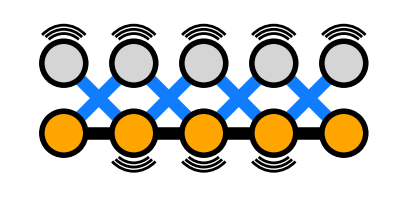

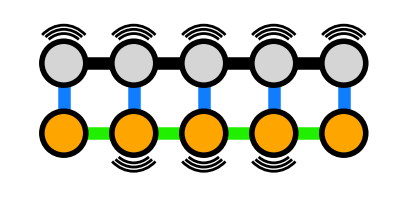

In [5]:
noise_orientations= [np.pi, 0]

# 1 is just the same as 2, where the complex beamsplitter coupling was moved to the gray modes
for idx in [0,2]:
    fig_chain, ax, G = arch.draw_chain_cell(
        irreducible_graphs[idx],
        num_following_unit_cells=5-1,
        positions_unit_cell='straight',
        distance_next_unit_cell=1,
        node_colors_unit_cell=['orange', '#D5D5D5'],
        noise_orientations=noise_orientations,
        orientation_detunings=[0, 0.6],
        kwargs_draw={'detuning_radius_factor': 0.6},
        mode_types=optimizer.mode_types,
        modes_without_noise=[0,-2],
        scale=0.7,
        filename=None#'frequency_splitter/plot/%i-chain.pdf'%idx
    )


Let us analyze the last chain in more detail

In [6]:
# One optimization run produced the following parameter set for the last chain, which works well for visualizing the key features of this chain
parameter_dict = {'Delta0': 0.0,
 'Delta1': 0.0,
 '|\\nu_{0,1}|': 1.1956423770144324,
 '|g_{0,0p}|': -1.8137722783560806,
 '|\\nu_{0,1p}|': 0.0,
 '|\\nu_{1,0p}|': 0.0,
 '|g_{1,1p}|': 3.665026744440978,
 '\\mathrm{arg}(\\nu_{0,1})': 872.1980812005634,
 '\\mathrm{arg}(g_{0,0p})': 0.440082133154661,
 '\\mathrm{arg}(\\nu_{0,1p})': 0.0,
 '\\mathrm{arg}(\\nu_{1,0p})': 0.0,
 '\\mathrm{arg}(g_{1,1p})': 0.0,
 'kappa_ext1': 2.651274107945164}

input_array = jnp.array([parameter_dict[var.name] for var in optimizer.all_variables_list])

omegas = np.linspace(-4.5, 4.5, 201)
scattering_chain = np.array(plot_functions['scattering_func'](omegas, input_array))

prefactors, scaling_rate, info = plot_functions['scaling_func'](omegas, input_array)

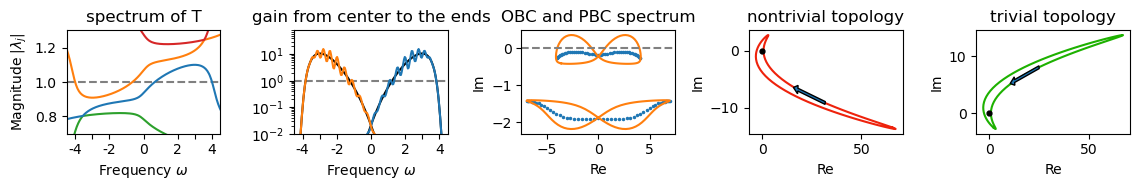

In [12]:
fig, axes = plt.subplots(ncols=5, figsize=(2.3*5,2.))

ax_EVs = axes[0]
ax_gain = axes[1]
ax_OBC_PBC = axes[2]
ax_det_left = axes[3]
ax_det_right = axes[4]

chain_length = plot_functions['chain_length']
idx_middle = 2 * (chain_length//2)
idx_left = 0
idx_right = 2 * (chain_length-1)

eigval_colors = ['C2', 'C0', 'C1', 'C3']
for idx in range(4):
    ax_EVs.plot(omegas, np.abs(info['eigvals'][:,idx]), color=eigval_colors[idx])


prefactor_bulk_right, scaling_rate_bulk_right = plot_functions['scaling_func_bulk_to_right'](omegas, input_array)
approximation_right = np.abs((prefactor_bulk_right[:,0,0] * scaling_rate_bulk_right**(chain_length//2 + 1)))**2

prefactor_bulk_left, scaling_rate_bulk_left = plot_functions['scaling_func_bulk_to_left'](omegas, input_array)
approximation_left = np.abs((prefactor_bulk_left[:,0,0] * scaling_rate_bulk_left**(chain_length//2 + 1)))**2

ax_gain.plot(omegas, approximation_right, color='black')
ax_gain.plot(omegas, approximation_left, color='black')

ax_gain.plot(omegas, np.abs(scattering_chain[:,idx_right,idx_middle])**2, color='C0')
ax_gain.plot(omegas, np.abs(scattering_chain[:,idx_left,idx_middle])**2, color='C1')

eigvals_OBC = jnp.linalg.eigvals(plot_functions['dynamical_matrix_OBC'](input_array))
eigvals_PBC = jnp.linalg.eigvals(plot_functions['dynamical_matrix_PBC'](input_array))
ks, eigvals_PBC_continuous = phelp.calc_continuous_PBC(optimizer.give_mus(input_array))

ax_OBC_PBC.plot(np.imag(eigvals_OBC), np.real(eigvals_OBC), label='OBC', marker='.', ls='None', markersize=3)
# ax_OBC_PBC.plot(np.imag(eigvals_PBC), np.real(eigvals_PBC), label='PBC', marker='.', ls='None')
for band_idx in range(2):
    ax_OBC_PBC.plot(np.imag(eigvals_PBC_continuous[:,band_idx]), np.real(eigvals_PBC_continuous[:,band_idx]), color='C1', marker='None',)
ax_OBC_PBC.axhline(0., color='gray', ls='dashed')

# ax_OBC_PBC.set_xticks([-4.,-2.,0,2,4])
# ax_OBC_PBC.set_ylim(-0.5, 0.4)
ax_OBC_PBC.set_xlim(-7.5, 7.5)

# ax_OBC_PBC.set_ylim(-2.4, -1.95)
# ax_OBC_PBC.axhline(-2.07)

# ax_forward.axhline(1., color='gray', ls='dashed', zorder=-100)

k_arrow = 4.
delta_k = 0.3
_, [det_H_k_arrow] = phelp.calc_det_H_k(optimizer.give_mus(input_array), omega=omega_left, ks=jnp.array([k_arrow]))
_, [det_H_delta_k] = phelp.calc_det_H_k(optimizer.give_mus(input_array), omega=omega_left, ks=jnp.array([k_arrow+delta_k]))
ax_det_left.arrow(np.real(det_H_k_arrow), np.imag(det_H_k_arrow), np.real(det_H_delta_k-det_H_k_arrow), np.imag(det_H_delta_k-det_H_k_arrow), zorder=100, width=0.5)

ks, det_H_k = phelp.calc_det_H_k(optimizer.give_mus(input_array), omega=omega_left)
# ax_det_left.plot(np.imag(det_H_k), np.real(det_H_k), color='#EE220C')
ax_det_left.plot(np.real(det_H_k), np.imag(det_H_k), color='#EE220C')


k_arrow = 1.
delta_k = 0.3
_, [det_H_k_arrow] = phelp.calc_det_H_k(optimizer.give_mus(input_array), omega=omega_right, ks=jnp.array([k_arrow]))
_, [det_H_delta_k] = phelp.calc_det_H_k(optimizer.give_mus(input_array), omega=omega_right, ks=jnp.array([k_arrow+delta_k]))
ax_det_right.arrow(np.real(det_H_k_arrow), np.imag(det_H_k_arrow), np.real(det_H_delta_k-det_H_k_arrow), np.imag(det_H_delta_k-det_H_k_arrow), zorder=100, width=0.5)

ks, det_H_k = phelp.calc_det_H_k(optimizer.give_mus(input_array), omega=omega_right)
# ax_det_right.plot(np.imag(det_H_k), np.real(det_H_k), color='#1DB100')
ax_det_right.plot(np.real(det_H_k), np.imag(det_H_k), color='#1DB100')

for ax in [ax_det_right, ax_det_left]:
    ax.plot([0], [0], color='black', ls='None', marker='o', markersize=3.5)

# ax_det_left.axhline(0, color='gray', ls='dashed', zorder=-100)


for ax in [ax_gain, ax_EVs]:
    ax.axhline(1., color='gray', ls='dashed', zorder=-100)
    ax.set_xlim(omegas[0], omegas[-1])

for ax in axes[:2]:
    ax.set_xticks([-4.,-3,-2.,0,2,3,4])
    ax.set_xticklabels([-4, '', -2, 0, 2, '', 4])
    # ax.axvline(-3., color='#EE220C', zorder=-100, ls='dashed')
    # ax.axvline(3., color='#1DB100', zorder=-100, ls='dashed')

ax_gain.set_yscale('log')
ax_gain.set_ylim([10**-2, 8*10**1])
# ax_gain.set_ylim([10**-2, 5*10**1])
ax_EVs.set_ylim(0.7, 1.3)
ax_EVs.set_yticks([0.8, 1., 1.2])

# ax_det.set_xlim(-1,1)
# ax_det.set_ylim(-1,1)
# ax_backward.legend(loc='center', bbox_to_anchor=(0.75, 0.55))

# ax_forward.set_xlabel('$\omega$')
# ax_forward.set_ylabel('forward gain')
# ax_backward.set_xlabel('$\omega$')
# ax_backward.set_ylabel('reverse gain')

ax_EVs.set_title('spectrum of T')
ax_gain.set_title('gain from center to the ends')
ax_OBC_PBC.set_title('OBC and PBC spectrum')
ax_det_right.set_title('trivial topology')
ax_det_left.set_title('nontrivial topology')

ax_EVs.set_xlabel(r'Frequency $\omega$')
ax_EVs.set_ylabel(r'Magnitude $|\lambda_j|$')
ax_gain.set_xlabel(r'Frequency $\omega$')

for ax in [ax_OBC_PBC, ax_det_right, ax_det_left]:
    ax.set_xlabel('Re')
    ax.set_ylabel('Im')


fig.tight_layout()
# plt.subplots_adjust(wspace=0)
# fig.savefig('frequency_splitter/plot/results.pdf', transparent=True)

# fig.savefig('frequency_splitter/dataset/' + str(file_idx).zfill(4) + '.pdf')